## Setup & Initialization

In [1]:
# Import necessary utilities from BRAILS:
from brails.utils import RAPIDUtils, Importer

## Step 1: Load Raster Orthomosaic File
This step initializes the `RAPIDUtils` class using the orthomosaic GeoTIFF file. This file should represent a stitched aerial image (e.g., from drones or satellite imagery). Please make sure the file path is correct and the file is a valid `.tif` or `.tiff` raster dataset.

In [2]:
# Load the orthomosaic raster file:
raster_path = 'DIRECTORY-PATH-OF-RASTER-FILE-HERE'
rapid_utils = RAPIDUtils(raster_path)

Detected orthomosaic data.
Applicable methods for this data type are: 'extract_aerial_imagery', 'get_mosaic_bbox_wgs84'.


## Step 2: Create a Region Boundary from Raster Extent
The `Importer` utility dynamically loads supported data classes. In this step, we use the raster’s spatial extent to define a region boundary polygon. This boundary serves as the spatial filter for retrieving building footprints, which will then guide the automated extraction of aerial imagery from the orthomosaic dataset specified in `raster_path`.

In [3]:
# Initialize the Importer:
importer = Importer()

# Define the region using the raster’s bounding box:
region_data = {
    "type": "locationPolygon",
    "data": rapid_utils.dataset_extent  # Automatically extracted extent in GeoJSON format
}

# Dynamically load and initialize RegionBoundary:
region_boundary_class = importer.get_class("RegionBoundary")
region_boundary_object = region_boundary_class(region_data)


## Step 3: Scrape Building Footprints from OpenStreetMap
Using the `OSM_FootprintScraper`, we retrieve building footprints from OpenStreetMap (OSM) within the defined region. These footprints are used to automate the extraction of corresponding image tiles from the raster dataset. This step requires an active internet connection. If no buildings are found in the specified area, the scraper will return an empty inventory.

In [4]:
# Get the footprint scraper class from the importer:
scraper_class = importer.get_class("OSM_FootprintScraper")

# Initialize the scraper (specifying that output units should be in feet):
scraper = scraper_class({'length': 'ft'})

# Scrape footprints in the specified region:
scraper_inventory = scraper.get_footprints(region_boundary_object)



Found a total of 503 building footprints in the bounding box: [-122.1421632630038, 47.69423131358076, -122.12908634292988, 47.70804716657085]


## Step 4: Extract Aerial Imagery with Overlaid Outlines
Now that we have both the building footprints and the raster dataset, we can extract image patches centered on each building. Optionally, the outlines of the buildings can be overlaid on these image tiles by setting the `overlay_asset_outline` input argument to True. To obtain non-overlaid images, simply set this argument to `False`.

After running this step, all cropped orthomosaic image tiles—one per building footprint—will be saved to the specified `output_dir`. The variable `image_set` holds an ImageSet object that contains metadata and references for the extracted images. Please note that the keys in `image_set` correspond directly to those in `scraper_inventory`, allowing you to trace each image back to its associated building footprint.

In [5]:
# Set the output directory for imagery:
output_dir = 'images_raster_test/overlaid_imagery'

# Extract imagery and overlay building outlines:
image_set = rapid_utils.extract_aerial_imagery(
    scraper_inventory,
    output_dir,
    overlay_asset_outline=True
)


Images will be saved to: /home/bacetiner/Documents/BrailsPlusPlus/examples/rapid_tools/images_raster_test/overlaid_imagery



Extracting aerial imagery...: 100%|███████████| 503/503 [00:25<00:00, 19.63it/s]


Extracted aerial imagery for a total of 397 assets.


## Optional: View an Extracted Image

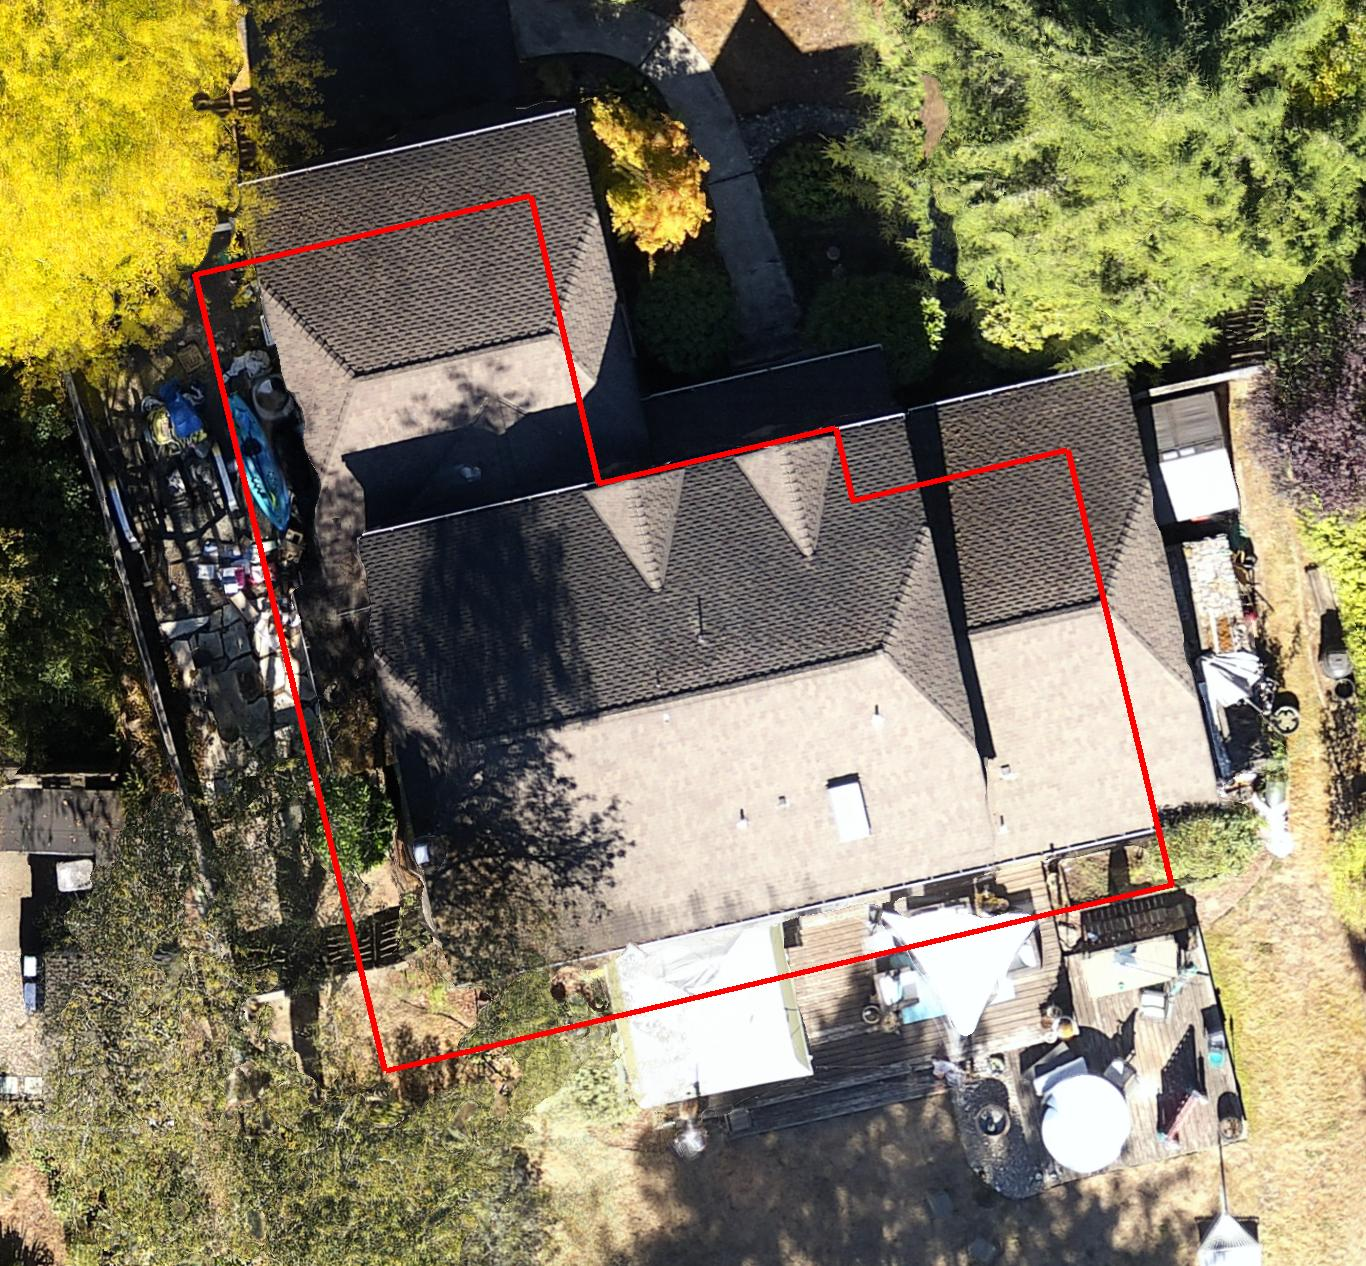

In [8]:
# Display a random-selected extracted image:
import random
from pathlib import Path
from IPython.display import Image as IPyImage, display

# Display a random extracted image, if available:
image_folder = Path(output_dir)

if image_set.images:
    random_image = random.choice(image_set.images)
    image_path = image_folder / random_image.filename
    display(IPyImage(filename=str(image_path)))